# Generating the container 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from ri_grad.components import *

In [ ]:
class Experiment:
    def __init__(self, container: Container, medium: Medium):
        self.container = container
        self.medium = medium

    def render(self, points: List[Tuple[float]], show_incidence_points: bool = False):
        _, ax = plt.subplots(figsize=(10, 6))
        n_layers = self.medium.n_layers

        # Generate a linear light to dark blue gradient
        gradient = np.linspace(.3, 1, n_layers)[::-1]
        colors = plt.cm.Blues(gradient)

        # Draw the layers with the generated colors
        for i in range(n_layers):
            layer_height = i * (self.container.height / n_layers)
            ax.fill_between(
                [0, self.container.width], 
                layer_height, 
                layer_height + (self.container.height / self.medium.n_layers), 
                color=colors[i], 
                alpha=0.5
            )  

        # plot the light beam trajectory
        x, y = zip(*points) 
        ax.scatter(x, y, color='red', linewidth=2, label='incidence points') if show_incidence_points else None
        ax.plot(x, y, color='red', linewidth=1, label='beam trajectory')

        # minor details (legend, remove ticks, set limits, aspect ratio, remove spines)
        ax.legend()
        ax.set_xlim(0, self.container.width)
        ax.set_ylim(0, self.container.height)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        plt.show()
            
    """
    Calculates the refraction angle given a beam, an incidence point on an interface and an incidence angle.
    """
    def _refraction(self, n1: float, n2: float, incidence_angle: float):        
        return np.arcsin((n1 / n2) * np.sin(incidence_angle))
    
    """
    Calculates the point of incidence on the next interface. 
    """
    def _transmission(self, incidence_point: Tuple[float], refracted_angle: float):
        x_offset = self.medium.layer_thickness * np.tan(refracted_angle)
        return (incidence_point[0] + x_offset, incidence_point[1] - self.medium.layer_thickness)

    """
    The first refraction is a special case because the beam incides on the side wall of the container.
    Returns the point of incidence on the first layer and the incidence angle.
    """
    def _first_refraction(self, incidence_point: Tuple[float], incidence_angle: float):
        incidence_layer = self.medium.get_layer_from_y(incidence_point[1])
        y_offset = - (incidence_point[1] - incidence_layer.y_bottom) # distance from the incidence point to the layer's top edge

        refracted_angle = self._refraction(1, incidence_layer.n, incidence_angle) # angle of refraction with the container wall
        print(f"Incident layer index: {incidence_layer.n}, refracted angle: {refracted_angle}")
        x_offset = abs(y_offset / np.tan(refracted_angle))

        return ((incidence_point[0] + x_offset, incidence_layer.y_bottom), (np.pi/2) - refracted_angle)

    """"
    Calculates the trajectory of the beam through the medium.
    Returns a list of points where the beam incides on each interface.
    """
    def beam_on(self, beam: Beam):        
        points: List[Tuple[float]] = [] # list of points where the beam incides on each interface
        incidence_point: Tuple[float] = (0, beam.y_0) # point of incidence on the container wall
        points.append(incidence_point)

        # first refraction
        incidence_point, incidence_angle = self._first_refraction((0, beam.y_0), beam.angle)
        points.append(incidence_point)

        # remaining refractions
        incident_layer_index = self.medium.get_layer_index_from_y(incidence_point[1]) # index of the layer where the beam incides
        for i in range(incident_layer_index, self.medium.n_layers, 1):
            layer = self.medium.layers[i]
            next_layer = self.medium.layers[i + 1] if i + 1 < self.medium.n_layers else None
            
            if next_layer is None: # last layer, no refraction
                incidence_point = self._transmission(incidence_point, incidence_angle)
                points.append(incidence_point)
                break
            
            refracted_angle = self._refraction(layer.n, next_layer.n, incidence_angle)
            incidence_point = self._transmission(incidence_point, refracted_angle)
            points.append(incidence_point)

            if incidence_point[0] > self.container.width: # beam exits the container
                break

            incidence_angle = refracted_angle

            if i % 20_000 == 0 and i > 0:  # print every 20,000 layers
                print(f"Layer {i}, incidence point: {incidence_point}, incidence angle: {incidence_angle}")

        return points

In [8]:
# experiment setup
container = Container(width=24.9, height=13.26)
beam = Beam(wavelength=500e-9, y_0=10.9, angle=np.deg2rad(22.75))

# Theoretical curve
modelo = np.load('data/model1.npy')

Incident layer index: 1.4285714285714286, refracted angle: 0.27411768911838347


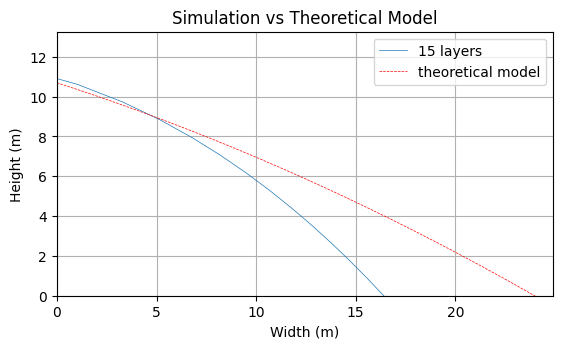

In [ ]:
def plot_models(number_of_layers_array):
    plt.figure()
    ax = plt.gca()
    ax.set_xlim(0, container.width)
    ax.set_ylim(0, container.height)
    ax.set_aspect('equal')
    for n_layers in number_of_layers_array:
        medium = Medium(
            container,
            n_0=1.0, 
            n_f=1.5, 
            n_layers=n_layers, 
            color='blue'
        )
        experiment = Experiment(container, medium)
        points = experiment.beam_on(beam)
        ax.plot(*zip(*points), linewidth=0.5, label=f'{n_layers} layers')
    ax.plot(modelo[:, 0], modelo[:, 1], color='red', linewidth=0.5, linestyle='dashed', label='theoretical model')
    ax.legend()
    plt.title('Simulation vs Theoretical Model')
    plt.xlabel('Width (m)')
    plt.ylabel('Height (m)')
    plt.grid()
    plt.show()

# # Plotting models with different number of layers
plot_models([15])